In [1]:
from datetime import datetime 
import time 
import pandas as pd 
import requests
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200 #allows us to see more of the text 

In [174]:
url = 'https://www.reddit.com/hot.json'

In [175]:
header = {'User-agent': 'el muneco'}

In [176]:
res = requests.get(url, headers=headers)
res

<Response [200]>

In [9]:
def scrape_reddit_posts(url_tag, header, loops, waittime, filename): 
    posts = []
    after = None
    for i in range(loops):
        print(i)
        if after == None:
            params = {}
        else:
            params = {'after': after}
        url = 'https://www.reddit.com/r/'+url_tag
        res = requests.get(url,params=params,headers=headers)
        if res.status_code == 200:

            data_json = res.json()
            after = data_json['data']['after']
            for row in data_json['data']['children']:
                post = {}
                post['subreddit'] = row['data']['subreddit']
                post['title'] = row['data']['title']
                post['num_comments'] = row['data']['num_comments']
                post['ups'] = row['data']['ups']
                post['downs'] = row['data']['downs']
                post['likes'] = row['data']['likes']
                post['score'] = row['data']['score']
                post['view_count'] = row['data']['view_count']
                post['url'] = row['data']['url']
                post['time_of_pull'] = datetime.now()
                posts.append(post)
        else:
            print(res.status_code)
            break
        time.sleep(waittime)   
    df = pd.DataFrame(posts)
    now = datetime.now()
    df.to_csv(filename+now.strftime('%Y%m%d%H%S'),index=False)

In [11]:
scrape_reddit_posts('football.json',header,40,1.5,'Reddit_football_')

In [ ]:
scrape_reddit_posts('nfl.json',header,40,1.5,'Reddit_nfl_')

### cleaning and EDA

In [2]:
nfl = pd.read_csv('../data/Reddit_nfl_201812161451')
nfl.drop(columns=['downs', 'likes','view_count'], inplace = True)

In [3]:
fut = pd.read_csv('../data/Reddit_football_201812161530')
fut.drop(columns=['downs', 'likes', 'view_count'], inplace = True)

In [4]:
nfl.shape

(999, 7)

In [5]:
fut.shape

(984, 7)

In [6]:
nfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 7 columns):
num_comments    999 non-null int64
score           999 non-null int64
subreddit       999 non-null object
time_of_pull    999 non-null object
title           999 non-null object
ups             999 non-null int64
url             999 non-null object
dtypes: int64(3), object(4)
memory usage: 54.7+ KB


In [10]:
frames = [fut,nfl]
df = pd.concat(frames)

In [11]:
df['is_juve'] = df['subreddit'].map(lambda x: 1 if x == 'football' else 0)

In [13]:
#this is good, pretty even classification 
df['subreddit'].value_counts(normalize=True)

nfl         0.503782
football    0.496218
Name: subreddit, dtype: float64

In [14]:
df.groupby('subreddit').is_juve.value_counts()

subreddit  is_juve
football   1          984
nfl        0          999
Name: is_juve, dtype: int64

In [15]:
pd.crosstab(df.subreddit,df.is_juve)

is_juve,0,1
subreddit,,
football,0,984
nfl,999,0


In [16]:
corpus = [title for title in df[df['subreddit'] \
                                == 'nfl']['title']]


In [17]:
footy_mob = [title for title in df[df['subreddit'] \
                                   == 'football']['title']] # if 'football' in title.lower()]


In [166]:
df['Avg length title'] = [(len(each.split())) for each in df['title']]

In [184]:
pol_scores = [sia.polarity_scores(each) for each in df[df['Avg length title'] > 0]['title']]
len(pol_scores)

1983

In [179]:
df['compound'] = [each['compound'] for each in pol_scores]
df['neg'] = [each['neg'] for each in pol_scores]
df['neu'] = [each['neu'] for each in pol_scores]
df['pos'] = [each['pos'] for each in pol_scores]

In [214]:
df.groupby('title', as_index=True, level=-1, squeeze=False, observed=True).mean().head(11)

,num_comments,score,ups,is_juve,Avg length title,compound,neg,neu,pos
0,504.5,39.5,39.5,0.5,6.5,0.00000,0.0000,1.0000,0.0000
1,55.0,37.0,37.0,0.5,4.0,0.00000,0.0000,1.0000,0.0000
2,274.5,3026.5,3026.5,0.5,29.0,0.00000,0.0000,1.0000,0.0000
3,49.0,787.5,787.5,0.5,9.5,-0.21075,0.1185,0.8815,0.0000
4,45.0,249.5,249.5,0.5,9.5,0.17000,0.0000,0.9030,0.0970
5,30.0,410.5,410.5,0.5,22.0,0.31580,0.0240,0.8155,0.1605
6,335.5,3385.0,3385.0,0.5,9.5,0.29295,0.0000,0.8390,0.1610
7,82.0,197.5,197.5,0.5,20.0,0.41170,0.0000,0.8360,0.1640
8,136.0,2057.0,2057.0,0.5,15.0,-0.42150,0.1720,0.8280,0.0000
9,34.5,170.5,170.5,0.5,31.5,-0.27870,0.0355,0.9645,0.0000


### Darth Vader Analysis

In [18]:
#instantiate SIA
sia = SentimentIntensityAnalyzer()

In [19]:
sia.polarity_scores('Help')

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4019}

In [20]:
sia.polarity_scores('I fucking hate the way you love')

{'neg': 0.327, 'neu': 0.328, 'pos': 0.344, 'compound': 0.0534}

In [21]:
sia.polarity_scores(corpus[44])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

### DF of sentiment analysis NFL

In [22]:
list_of_polarities = [sia.polarity_scores(each) for each in corpus]

In [23]:
list_of_polarities[0:11]

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.048, 'neu': 0.896, 'pos': 0.056, 'compound': 0.0742},
 {'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'compound': 0.5859},
 {'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'compound': 0.4019},
 {'neg': 0.141, 'neu': 0.859, 'pos': 0.0, 'compound': -0.4215},
 {'neg': 0.071, 'neu': 0.929, 'pos': 0.0, 'compound': -0.5574},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

In [24]:
nfl['compound'] = [each['compound'] for each in list_of_polarities]
nfl['neg'] = [each['neg'] for each in list_of_polarities]
nfl['neu'] = [each['neu'] for each in list_of_polarities]
nfl['pos'] = [each['pos'] for each in list_of_polarities]

In [25]:
#nfl.drop('ups', axis=1, inplace=True)
nfl.shape

(999, 11)

In [26]:
vader_nfl =  nfl[['num_comments', 'score', 'time_of_pull','title', 'url', 'compound', 'neg', 'neu', 'pos']]

Vader analysis is the process of statistically working out the corpus' polarity. Vader is based on lexicon of sentiment related words. 

In [100]:
neg_vader_nfl = vader_nfl.sort_values(by='neg', ascending=False).head(50)

In [101]:
pos_vader_nfl = vader_nfl.sort_values(by='pos', ascending=False).head(50)

In [110]:
for each in neg_vader_nfl['title']:
    print(len(each.split()))

In [242]:
# neg_vader_nfl['Avg length title'] = [(len(each.split())) for each in neg_vader_nfl['title'] ]
neg_vader_nfl.head()

,num_comments,score,time_of_pull,title,url,compound,neg,neu,pos,Avg length title
516,442,560,2018-12-16 14:48:15.491963,What’s the worst “ lose - lose trade “ in NFL history ?,https://www.reddit.com/r/nfl/comments/a5se2t/whats_the_worst_lose_lose_trade_in_nfl_history/,-0.8591,0.613,0.387,0.000,13
396,40,0,2018-12-16 14:48:03.687481,Offensive holding change.,https://www.reddit.com/r/nfl/comments/a6jai1/offensive_holding_change/,-0.4588,0.600,0.400,0.000,3
585,39,18,2018-12-16 14:48:21.004881,[PFF] Offensive tackles who allow the lowest pressures per pass blocking snap,https://twitter.com/pff/status/1073333499766149120?s=21,-0.8225,0.541,0.361,0.098,12
385,10,38,2018-12-16 14:48:03.687458,"Suicide, Quarterbacks and the Hilinski Family",https://www.nytimes.com/2018/12/13/sports/football/ryan-hilinski-tyler-suicide-quarterback.html?action=click&amp;module=Top%20Stories&amp;pgtype=Homepage,-0.6705,0.474,0.526,0.000,6
316,26,0,2018-12-16 14:47:58.067635,Will John Harbaugh get fired?,https://www.reddit.com/r/nfl/comments/a6o097/will_john_harbaugh_get_fired/,-0.5574,0.474,0.526,0.000,5


In [112]:
pos_vader_nfl['Avg length title'] = [(len(each.split())) for each in pos_vader_nfl['title']]
pos_vader_fut

In [245]:
pos_vader_nfl['pos'].mean()

0.42849999999999994

In [246]:
neg_vader_nfl['neg'].mean()

0.36295999999999984

### DF sent analysis for footy_mob

In [58]:
sia = SentimentIntensityAnalyzer()

In [59]:
footy_mob[11]

'Cristiano Ronaldo to receive two-year prison sentence'

In [60]:
list_of_polarities_footy = [sia.polarity_scores(each) for each in \
                            footy_mob]


In [61]:
list_of_polarities_footy[1:6]

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.237, 'neu': 0.763, 'pos': 0.0, 'compound': -0.4215},
 {'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.34},
 {'neg': 0.0, 'neu': 0.735, 'pos': 0.265, 'compound': 0.5574}]

In [202]:
#some info
len(list_of_polarities)

len(list_of_polarities_footy)

fut.shape

len(footy_mob)

fut.shape

999

In [62]:
list_of_polarities_fut = [sia.polarity_scores(each) for each in fut['title']]

In [63]:
#this column is useless, same as score 
fut.drop(columns='ups', axis=1, inplace=True)

In [65]:
fut['compound'] = [each['compound'] for each in list_of_polarities_footy]
fut['neg'] = [each['neg'] for each in list_of_polarities_footy]
fut['neu'] = [each['neu'] for each in list_of_polarities_footy]
fut['pos'] = [each['pos'] for each in list_of_polarities_footy]

In [66]:
vader_fut = fut[['num_comments', 'score', 'time_of_pull','title', \
                'url', 'compound', 'neg', 'neu', 'pos']]

In [67]:
#not sure how i got duplicate post via title, but drop them with this shit
vader_fut.drop_duplicates('title',inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [90]:
pos_vader_fut = vader_fut.sort_values(by='pos', ascending=False).head(50)

In [92]:
neg_vader_fut = vader_fut.sort_values(by='neg', ascending=False).head(50)

#negative post have longer titles

### trying 2 plots

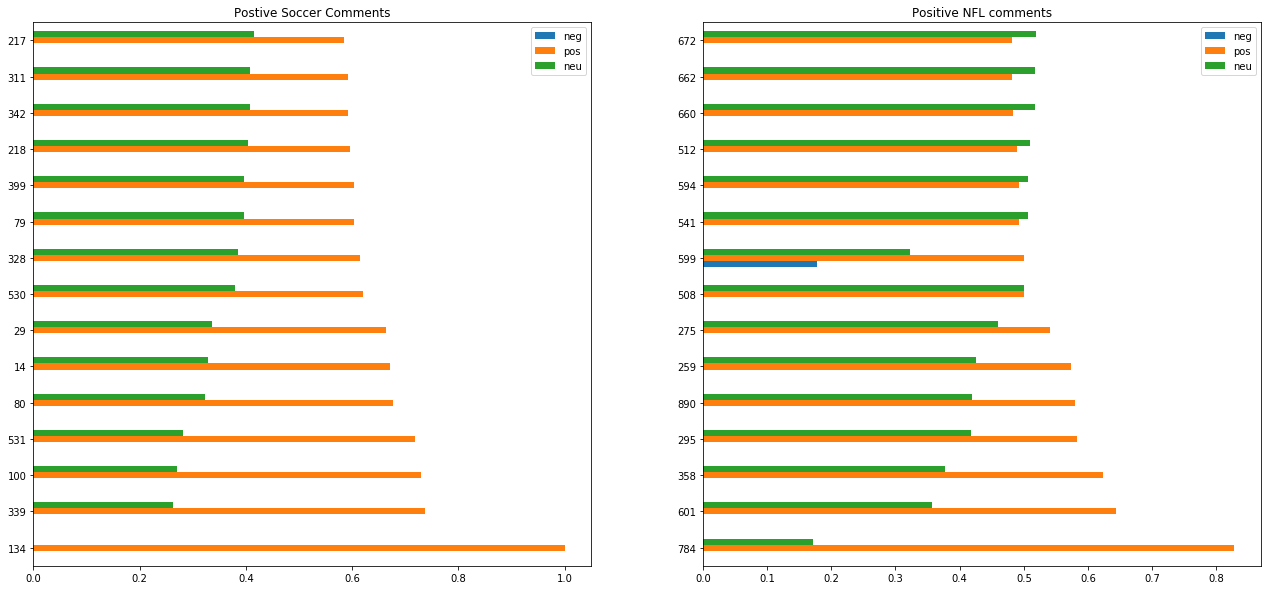

In [240]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

vader_fut[['neg','pos','neu']] \
.sort_values(by = 'pos',ascending=False) \
.head(15) \
.plot(kind="barh", title="Postive Soccer Comments", ax=ax[0])



vader_nfl[['neg','pos','neu']] \
.sort_values(by='pos',ascending=False) \
.head(15) \
.plot(kind="barh", title="Positive NFL comments", ax=ax[1]);



In [270]:
vader_fut.loc[134]
#Help?
# I'm very slowly starting to get into football. I've watched a couple games but there's a couple things i want opinions on.

# What team (as in the Champion's League, i think it's called) should i support?
# Ask your dad, uncle, cousin, your team has to be tied down to your culture
# Anything football related I should do?
# go to different pubs that are affiliated with different clubs and choose which crowd can drannkkk
# Is it even worth getting into football even though i'm a teen already?
# Only you have the that answer 
# Any general pointers or suggestions
# never ever change clubs, not even for your favorite player, the club is always bugger than the player 


num_comments                                                          6
score                                                                 0
time_of_pull                                 2018-12-16 15:21:20.202348
title                                                             Help?
url             https://www.reddit.com/r/football/comments/a0zikg/help/
compound                                                         0.4019
neg                                                                   0
neu                                                                   0
pos                                                                   1
Name: 134, dtype: object

In [263]:
vader_nfl.loc[794]
#sia.polarity_scores('Oakland Coliseum reaches new low with dead mice in soda machine')

num_comments                              12
score                                      0
time_of_pull      2018-12-16 14:48:35.430971
title                       Top 10 MVP Snubs
url             https://youtu.be/4k0qHE6RRYc
compound                             -0.3182
neg                                    0.449
neu                                     0.29
pos                                    0.261
Name: 794, dtype: object

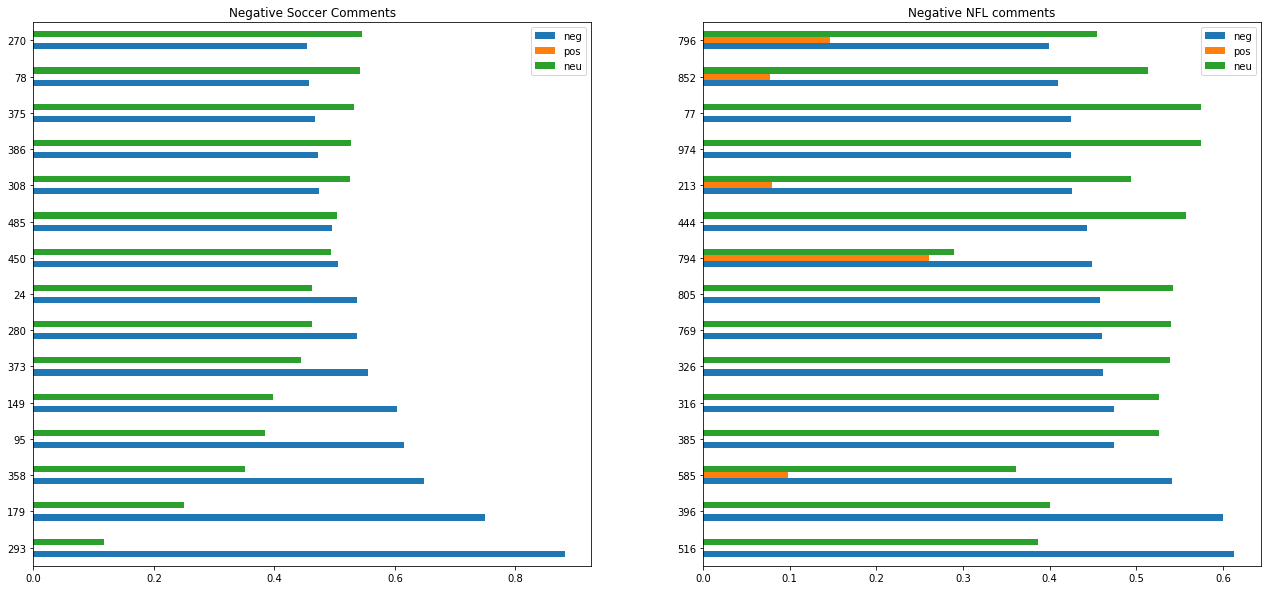

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))

vader_fut[['neg','pos','neu']] \
.sort_values(by = 'neg',ascending=False) \
.head(15) \
.plot(kind="barh", title="Negative Soccer Comments", ax=ax[0])



vader_nfl[['neg','pos','neu']] \
.sort_values(by='neg',ascending=False) \
.head(15) \
.plot(kind="barh", title="Negative NFL comments", ax=ax[1]);

In [260]:
vader_fut.loc[293]

num_comments                                                                                                                    0
score                                                                                                                           0
time_of_pull                                                                                           2018-12-16 15:21:31.941959
title                                                                                    Zaha reveals racist abuse, death threats
url             https://www.msn.com/en-gb/sport/premier-league/zaha-reveals-racist-abuse-death-threats/ar-BBP7UdL?ocid=spartanntp
compound                                                                                                                  -0.9423
neg                                                                                                                         0.882
neu                                                                                       

In [73]:
vader_fut.loc[179]
print(sia.polarity_scores('Penalty Rebounds'))
#The word Penalty is really negative in this post 

{'neg': 0.75, 'neu': 0.25, 'pos': 0.0, 'compound': -0.4588}


In [74]:
sia.polarity_scores('Player takes a penalty, the keeper saves it, but the player scores the rebound. How would this be recorded? Is it still counted as a penalty, or is it counted as a normal goal? The logical part of me says goal, but I also know football is occasionally weird.')

{'neg': 0.16, 'neu': 0.84, 'pos': 0.0, 'compound': -0.7888}

In [75]:
sia.polarity_scores('Zaha reveals racist abuse, death threats')

{'neg': 0.882, 'neu': 0.118, 'pos': 0.0, 'compound': -0.9423}

In [76]:
#Zahas post
sia.polarity_scores('Crystal Palace forward Wilfried Zaha has revealed he suffered racist abuse and threats to his family following Sunday’s 2-2 draw with Arsenal in the Premier League. Zaha was awarded a late penalty after being caught in the area by Gunners midfielder Granit Xhaka, with Luka Milivojevic converting the resulting penalty to earn Palace a point and end Arsenals winning run in all competitions at 11 matches.')

{'neg': 0.245, 'neu': 0.68, 'pos': 0.074, 'compound': -0.9337}

In [77]:
#short post are being heavily weighted. Vader isnt working good. See how it scores on post longer than 5 words. 
# len('title example'.split()), #how does post 134 score without the exclamation. 
print(len('Pogba no longer Vice Captain!'.split()))
print(sia.polarity_scores('Pogba no longer Vice Captain!'))

5
{'neg': 0.384, 'neu': 0.616, 'pos': 0.0, 'compound': -0.3595}


In [95]:
# creating new column
pos_vader_fut['Avg length title'] = [(len(each.split())) for each in pos_vader_fut['title']]

In [99]:
#creating new column
neg_vader_fut['Avg length title'] =[(len(each.split())) for each in neg_vader_fut['title']]
len(neg_vader_fut)

50

In [243]:
pos_vader_fut['pos'].mean()
#one 11 length comment.if removed we go down to 3.5

0.5111599999999998

In [244]:
neg_vader_fut['neg'].mean()

0.42528000000000005

In [163]:
#short post are being heavily weighted. Vader isnt working good. See how it scores on post longer than 5 words.
[sia.polarity_scores(each) for each in neg_vader_fut[neg_vader_fut['Avg length title'] > 5]['title']]

[{'neg': 0.882, 'neu': 0.118, 'pos': 0.0, 'compound': -0.9423},
 {'neg': 0.603, 'neu': 0.397, 'pos': 0.0, 'compound': -0.8442},
 {'neg': 0.496, 'neu': 0.504, 'pos': 0.0, 'compound': -0.7845},
 {'neg': 0.473, 'neu': 0.527, 'pos': 0.0, 'compound': -0.6697},
 {'neg': 0.467, 'neu': 0.533, 'pos': 0.0, 'compound': -0.6571},
 {'neg': 0.457, 'neu': 0.543, 'pos': 0.0, 'compound': -0.4939},
 {'neg': 0.455, 'neu': 0.273, 'pos': 0.273, 'compound': -0.25},
 {'neg': 0.447, 'neu': 0.553, 'pos': 0.0, 'compound': -0.8439},
 {'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.6113},
 {'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.6808},
 {'neg': 0.438, 'neu': 0.562, 'pos': 0.0, 'compound': -0.4404},
 {'neg': 0.403, 'neu': 0.597, 'pos': 0.0, 'compound': -0.4019},
 {'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compound': -0.4939},
 {'neg': 0.383, 'neu': 0.617, 'pos': 0.0, 'compound': -0.7351},
 {'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'compound': -0.6597},
 {'neg': 0.372, 'neu': 0.628, 'pos': 0.0, 

In [215]:
[sia.polarity_scores(each) for each in pos_vader_fut[pos_vader_fut['Avg length title'] > 5]['title']]

[{'neg': 0.0, 'neu': 0.329, 'pos': 0.671, 'compound': 0.8807},
 {'neg': 0.0, 'neu': 0.385, 'pos': 0.615, 'compound': 0.8807},
 {'neg': 0.0, 'neu': 0.397, 'pos': 0.603, 'compound': 0.8225},
 {'neg': 0.0, 'neu': 0.404, 'pos': 0.596, 'compound': 0.7096},
 {'neg': 0.0, 'neu': 0.415, 'pos': 0.585, 'compound': 0.9136},
 {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.6124},
 {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.875},
 {'neg': 0.0, 'neu': 0.485, 'pos': 0.515, 'compound': 0.6486},
 {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.6597},
 {'neg': 0.0, 'neu': 0.559, 'pos': 0.441, 'compound': 0.6948},
 {'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'compound': 0.296},
 {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.7003},
 {'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'compound': 0.8176},
 {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.6369},
 {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.6369},
 {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'compound': 0.680